# Imports

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from google.colab import files
from tensorflow import keras
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.experimental import SGD
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, Conv1D 
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Helpers

In [61]:
def scale(load_df, 
          start_train_date,
          end_val_date,
          start_test_date,
          end_test_date):
  
  train_val_df = load_df[(load_df.index >= start_train_date) &
                        (load_df.index <= end_val_date)]
  test_df = load_df[(load_df.index >= start_test_date) &
                    (load_df.index <= end_test_date)]

  scaler = MinMaxScaler()
  train_val_scaled = scaler.fit_transform(train_val_df)
  train_val_df_scaled = pd.DataFrame(train_val_scaled,
                                    columns=train_val_df.columns,
                                    index=train_val_df.index)
  test_scaled = scaler.transform(test_df)
  test_df_scaled = pd.DataFrame(test_scaled,
                                columns=test_df.columns,
                                index=test_df.index)

  load_df_scaled = pd.concat([train_val_df_scaled, test_df_scaled], axis=0)

  return load_df_scaled, scaler

def reframing(X_df, Y_df, n_backwards=1, skip_steps_forward=0, n_forwards=1):

  feat_cols, feat_names = [], []
  # iterate through all columns
  for col_index, col_name in enumerate(X_df.columns):
    series = X_df[col_name].copy()
    # input sequence (t, t-1, ... ,t-(n_backwards+1) )
    for b in range(n_backwards):
      feat_cols.append(series.shift(b))
      feat_names.append(f'{col_name}_(t-{b})')
  
  # put it all together
  X = pd.concat(feat_cols, axis=1)
  X.columns = feat_names
  # drop rows with NaN values
  X.dropna(inplace=True)
  X_index = X.index
    
  # forecast sequence (t + SKIP_STEPS_FORWARD + 1, ... , t + n_forwards)
  series = Y_df
  target_cols, target_names = [], []
  for f in range(skip_steps_forward + 1, n_forwards): 
    target_cols.append(Y_df.shift(-f))
    if f == 0:
      target_names.append(f'{Y_df.name}_t')
    else:
      target_names.append(f'{Y_df.name}_(t+{f})')

  # put it all together
  Y = pd.concat(target_cols, axis=1)
  Y.columns = target_names
  # drop rows with NaN values
  Y.dropna(inplace=True)
  Y_index = Y.index
  
  return X, X_index, Y, Y_index


def reshapeLSTMInput(reframed, steps):
    values = reframed.values
    # reshape input to be 3D [samples, timesteps, features]
    input = values.reshape(
        (values.shape[0], steps, int(values.shape[1] / steps)))

    print(input.shape)

    return input


def train(D_in, T, D_out, EPOCHS, BATCH_SIZE):

  checkpoint_filepath='./checkpoint'
  model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                              monitor='val_mape', 
                                              save_best_only=True)

  my_callbacks = [
      EarlyStopping(patience=5),
      model_checkpoint_callback,
      # ReduceLROnPlateau(patience=5, factor=0.33)
  ]

  inputs = Input(shape=(T, D_in))
  x = Conv1D(256, 1, activation='relu')(inputs)
  x = Conv1D(512, 3, activation='relu')(x)
  x = Conv1D(1024, 5, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Flatten()(x)
  x = Dense(512, activation='relu')(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.2)(x)
  outputs = Dense(D_out)(x)

  model = Model(inputs, outputs)

  model.compile(
      optimizer=Adam(),
      loss="mape",
      metrics=["mape", "mae"],
  )

  history = model.fit(X_train_3D,
                      y_train_df, 
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS, 
                      validation_data=(X_val_3D, y_val_df),
                      callbacks=my_callbacks)
  
  model.load_weights(checkpoint_filepath)

  return model, history

# MAIN

In [192]:
DAYS_BACK = 2*7
DAYS_TO_SKIP = 10
STEPS_FORWARD = 24    # 1 day
SKIP_STEPS_FORWARD = 24 * DAYS_TO_SKIP
LAST_STEP_FORWARD = STEPS_FORWARD + SKIP_STEPS_FORWARD
LAST_STEP_BACK = 24

# keep 1 year for testing
START_TEST_DATE = pd.to_datetime('2018-01-01') - pd.to_timedelta(LAST_STEP_FORWARD, 'h')
END_TEST_DATE = START_TEST_DATE + pd.DateOffset(years=1)

END_VAL_DATE = START_TEST_DATE - pd.to_timedelta(1, 'h')
START_VAL_DATE = pd.to_datetime('2017-01-01') - pd.to_timedelta(LAST_STEP_FORWARD, 'h')

START_TRAIN_DATE = pd.to_datetime('2010-10-01')
END_TRAIN_DATE = START_VAL_DATE - pd.to_timedelta(1, 'h')

TARGET = "TOTAL_CONS"

print(f"Train from {START_TRAIN_DATE} to {END_TRAIN_DATE}")
print(f"Validation from {START_VAL_DATE} to {END_VAL_DATE}")
print(f"Test from {START_TEST_DATE} to {END_TEST_DATE}")

Train from 2010-10-01 00:00:00 to 2016-12-20 23:00:00
Validation from 2016-12-21 00:00:00 to 2017-12-20 23:00:00
Test from 2017-12-21 00:00:00 to 2018-12-21 00:00:00


In [193]:
load_df = pd.read_csv("/content/FINAL_DATASET_2.csv")
load_df.set_index(pd.to_datetime(load_df["Timestamp"]), inplace=True)
load_df.drop("Timestamp", axis=1, inplace=True)

TARGET_POS = np.where(load_df.columns == TARGET)[0][0]

load_df_scaled, scaler = scale(load_df,
                               START_TRAIN_DATE,
                               END_VAL_DATE,
                               START_TEST_DATE,
                               END_TEST_DATE)

,TOTAL_CONS,Weekend,Holiday,temp,humidity,cos_hour,sin_hour,cos_weekday,sin_weekday,cos_dayOfYear,sin_dayOfYear
Timestamp,,,,,,,,,,,
2010-10-01 00:00:00,4390.054,0,0,19.70,60.0,1.000000,0.000000,-0.900969,-0.433884,0.004304,-0.999991
2010-10-01 01:00:00,4046.071,0,0,19.61,60.0,0.965926,0.258819,-0.900969,-0.433884,0.004304,-0.999991
2010-10-01 02:00:00,3885.451,0,0,18.37,72.0,0.866025,0.500000,-0.900969,-0.433884,0.004304,-0.999991
2010-10-01 03:00:00,3808.100,0,0,18.05,72.0,0.707107,0.707107,-0.900969,-0.433884,0.004304,-0.999991
2010-10-01 04:00:00,3782.623,0,0,17.92,72.0,0.500000,0.866025,-0.900969,-0.433884,0.004304,-0.999991
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-22 19:00:00,4281.942,1,0,11.83,62.0,0.258819,-0.965926,0.623490,-0.781831,0.793572,-0.608477
2020-11-22 20:00:00,4091.488,1,0,11.76,66.0,0.500000,-0.866025,0.623490,-0.781831,0.793572,-0.608477
2020-11-22 21:00:00,3738.827,1,0,11.61,71.0,0.707107,-0.707107,0.623490,-0.781831,0.793572,-0.608477


In [195]:
time_weather_cols = load_df_scaled.drop(TARGET, axis=1).columns

# for col in load_df_scaled.columns:
for day_back in range(1, DAYS_BACK+1):
  load_df_scaled[TARGET + f'_(D-{day_back})'] = load_df_scaled[TARGET].shift(24 * day_back)

# shift future values
for col in time_weather_cols:
  load_df_scaled[col + f'_(t+{LAST_STEP_FORWARD})'] = load_df_scaled[col].shift(-LAST_STEP_FORWARD)
  load_df_scaled.drop(col, axis=1, inplace=True)

load_df_scaled.dropna(inplace=True)
load_df_scaled.shape

(71473, 25)

In [196]:
load_df_scaled.columns[:50]

Index(['TOTAL_CONS', 'TOTAL_CONS_(D-1)', 'TOTAL_CONS_(D-2)',
       'TOTAL_CONS_(D-3)', 'TOTAL_CONS_(D-4)', 'TOTAL_CONS_(D-5)',
       'TOTAL_CONS_(D-6)', 'TOTAL_CONS_(D-7)', 'TOTAL_CONS_(D-8)',
       'TOTAL_CONS_(D-9)', 'TOTAL_CONS_(D-10)', 'TOTAL_CONS_(D-11)',
       'TOTAL_CONS_(D-12)', 'TOTAL_CONS_(D-13)', 'TOTAL_CONS_(D-14)',
       'Weekend_(t+264)', 'Holiday_(t+264)', 'temp_(t+264)',
       'humidity_(t+264)', 'cos_hour_(t+264)', 'sin_hour_(t+264)',
       'cos_weekday_(t+264)', 'sin_weekday_(t+264)', 'cos_dayOfYear_(t+264)',
       'sin_dayOfYear_(t+264)'],
      dtype='object')

In [197]:
X_orig, X_index, Y_orig, Y_index = reframing(load_df_scaled, 
                                             load_df_scaled[TARGET], 
                                             n_backwards=LAST_STEP_BACK,
                                             skip_steps_forward=SKIP_STEPS_FORWARD,
                                             n_forwards=LAST_STEP_FORWARD+1)

common_index = X_index.intersection(Y_index)
X_df = X_orig.loc[common_index]
Y_df = Y_orig.loc[common_index]

load_df_scaled_reframed = pd.concat([X_df, Y_df], axis=1)
load_df_scaled_reframed.shape

(71186, 624)

In [198]:
load_train_df_scaled_reframed = load_df_scaled_reframed[(load_df_scaled_reframed.index >= START_TRAIN_DATE) & 
                                                        (load_df_scaled_reframed.index <= END_TRAIN_DATE)]

load_val_df_scaled_reframed = load_df_scaled_reframed[(load_df_scaled_reframed.index >= START_VAL_DATE) & 
                                                      (load_df_scaled_reframed.index <= END_VAL_DATE)]

load_test_df_scaled_reframed = load_df_scaled_reframed[(load_df_scaled_reframed.index >= START_TEST_DATE) & 
                                                       (load_df_scaled_reframed.index <= END_TEST_DATE)]

load_train_df_scaled_reframed = shuffle(load_train_df_scaled_reframed)    

X_train_df = load_train_df_scaled_reframed.iloc[:, :-STEPS_FORWARD]
y_train_df = load_train_df_scaled_reframed.iloc[:, -STEPS_FORWARD:]

X_val_df = load_val_df_scaled_reframed.iloc[:, :-STEPS_FORWARD]
y_val_df = load_val_df_scaled_reframed.iloc[:, -STEPS_FORWARD:]

X_test_df = load_test_df_scaled_reframed.iloc[:, :-STEPS_FORWARD]
y_test_df = load_test_df_scaled_reframed.iloc[:, -STEPS_FORWARD:]

X_train_3D = reshapeLSTMInput(X_train_df, steps=LAST_STEP_BACK)
X_val_3D = reshapeLSTMInput(X_val_df, steps=LAST_STEP_BACK)
X_test_3D = reshapeLSTMInput(X_test_df, steps=LAST_STEP_BACK)

(54193, 24, 25)
(8760, 24, 25)
(8233, 24, 25)


In [213]:
model, history = train(D_in=X_train_3D.shape[2], 
                       T=X_train_3D.shape[1],
                       D_out=y_train_df.shape[1], 
                       EPOCHS=5, 
                       BATCH_SIZE=64)

Epoch 1/5
847/847 [==============================] - ETA: 0s - loss: 16.8584 - mape: 16.8584 - mae: 0.0565

847/847 [==============================] - 8s 7ms/step - loss: 16.8584 - mape: 16.8584 - mae: 0.0565 - val_loss: 2865.5820 - val_mape: 2865.5820 - val_mae: 0.0367
Epoch 2/5
842/847 [============================>.] - ETA: 0s - loss: 11.3229 - mape: 11.3229 - mae: 0.0381

847/847 [==============================] - 6s 7ms/step - loss: 11.3210 - mape: 11.3210 - mae: 0.0381 - val_loss: 2384.3047 - val_mape: 2384.3047 - val_mae: 0.0409
Epoch 3/5
847/847 [==============================] - 4s 5ms/step - loss: 10.4617 - mape: 10.4617 - mae: 0.0352 - val_loss: 2551.3474 - val_mape: 2551.3474 - val_mae: 0.0426
Epoch 4/5
847/847 [==============================] - 4s 5ms/step - loss: 9.9433 - mape: 9.9433 - mae: 0.0334 - val_loss: 3816.6274 - val_mape: 3816.6274 - val_mae: 0.0391
Epoch 5/5
847/847 [==============================] - 4s 5ms/step - loss: 9.5882 - mape: 9.5882 - mae: 0.0322 - val_loss: 3758.5806 - val_mape: 3758.5806 - val_mae: 0.0386


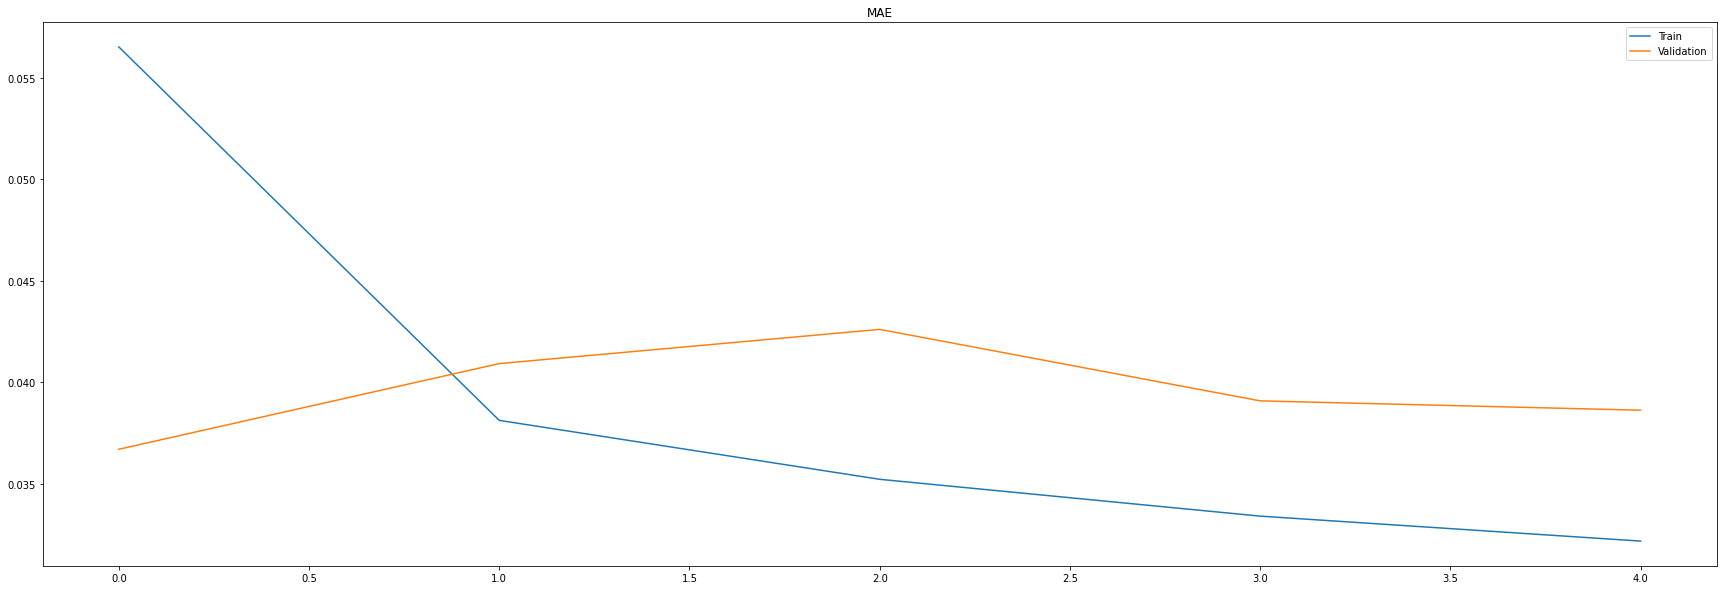

In [214]:
plt.figure(figsize=(30, 10))
plt.plot(history.history["mae"], label="Train")
plt.plot(history.history["val_mae"], label="Validation")
plt.title("MAE")
plt.legend()
plt.show()

In [215]:
preds_scaled = model.predict(X_test_3D)
preds_df_scaled = pd.DataFrame(preds_scaled, columns=np.arange(1, STEPS_FORWARD+1), index=y_test_df.index)

258/258 [==============================] - 1s 2ms/step


In [216]:
preds_df_unscaled = pd.DataFrame(columns=np.arange(1, STEPS_FORWARD+1), index=preds_df_scaled.index)
for i, col in enumerate(preds_df_scaled.columns):
  preds_df_unscaled[i+1] = scaler.data_min_[TARGET_POS] + preds_df_scaled[col].to_numpy() * (scaler.data_max_[TARGET_POS] - scaler.data_min_[TARGET_POS])

real_df_unscaled = pd.DataFrame(columns=np.arange(1, STEPS_FORWARD+1), index=preds_df_unscaled.index)
for i, col in enumerate(y_test_df.columns):
  real_df_unscaled[i+1] = scaler.data_min_[TARGET_POS] + y_test_df[col].to_numpy() * (scaler.data_max_[TARGET_POS] - scaler.data_min_[TARGET_POS])

In [217]:
# preds_df_unscaled = pd.DataFrame(columns=np.arange(1, STEPS_FORWARD+1))
# for col in preds_df_scaled.columns:
#   preds_df_unscaled[col] = preds_df_scaled[col] * scaler.max_abs_[TARGET_POS]

# real_df_unscaled = pd.DataFrame(columns=np.arange(1, STEPS_FORWARD+1), index=preds_df_unscaled.index)
# for i, col in enumerate(y_test_df.columns):
#   real_df_unscaled[i+1] = y_test_df[col].to_numpy() * scaler.max_abs_[TARGET_POS]

In [218]:
mape_list = list()
step_results_dict = {}
for step in range(1, STEPS_FORWARD + 1):
  step_index = real_df_unscaled.index + pd.to_timedelta(SKIP_STEPS_FORWARD + step, 'h')
  step_results_df = pd.DataFrame(
      {
          "real": real_df_unscaled.loc[:, step].to_numpy(),
          "predictions": preds_df_unscaled.loc[:, step].to_numpy()
      },
      index=step_index
  )
  step_results_df['abs_error'] = abs(step_results_df['real'] - step_results_df['predictions'])
  step_results_df['ape'] = np.where(step_results_df['real'] == 0, np.NaN, 100 * step_results_df['abs_error']/step_results_df['real'])
  step_mape = step_results_df['ape'].mean()
  mape_list.append(step_mape)
  print(f"Step {step} -> MAPE = {step_mape}")

  step_results_dict[step] = step_results_df
mape = np.array(mape_list).mean()
print(f"\nMAPE = {mape}")

Step 1 -> MAPE = 7.32955048681387
Step 2 -> MAPE = 7.192890914450852
Step 3 -> MAPE = 6.868599745514636
Step 4 -> MAPE = 7.001395016851791
Step 5 -> MAPE = 7.491339402251101
Step 6 -> MAPE = 7.610148261189156
Step 7 -> MAPE = 7.7231695300315515
Step 8 -> MAPE = 7.874894382944945
Step 9 -> MAPE = 7.575660574944483
Step 10 -> MAPE = 7.311305065158597
Step 11 -> MAPE = 7.382304642464176
Step 12 -> MAPE = 7.355280646472696
Step 13 -> MAPE = 7.103672202329782
Step 14 -> MAPE = 6.876259014783627
Step 15 -> MAPE = 7.062769390201331
Step 16 -> MAPE = 7.233980316848057
Step 17 -> MAPE = 7.1513998863183135
Step 18 -> MAPE = 7.285418735108845
Step 19 -> MAPE = 7.393730431918378
Step 20 -> MAPE = 7.08557079366216
Step 21 -> MAPE = 7.592961558544985
Step 22 -> MAPE = 7.32233446565211
Step 23 -> MAPE = 7.978378381322574
Step 24 -> MAPE = 7.385931998767905

MAPE = 7.341206076856079


In [219]:
step_results_dict[1]

,real,predictions,abs_error,ape
Timestamp,,,,
2017-12-31 01:00:00,4233.823,4165.793457,68.029543,1.606811
2017-12-31 02:00:00,4176.828,4122.291016,54.536984,1.305703
2017-12-31 03:00:00,4193.562,4069.652344,123.909656,2.954759
2017-12-31 04:00:00,4168.712,4055.743408,112.968592,2.709916
2017-12-31 05:00:00,4181.111,4050.663574,130.447426,3.119923
...,...,...,...,...
2018-12-08 21:00:00,5752.815,5746.242676,6.572324,0.114245
2018-12-08 22:00:00,5311.412,5275.191406,36.220594,0.681939
2018-12-08 23:00:00,4928.011,4776.793945,151.217055,3.068521


In [206]:
load_df[load_df.index == step_results_dict[1].index[0]]

,TOTAL_CONS,Weekend,Holiday,temp,humidity,cos_hour,sin_hour,cos_weekday,sin_weekday,cos_dayOfYear,sin_dayOfYear
Timestamp,,,,,,,,,,,
2017-12-31 01:00:00,4233.823,1,1,7.91,58.0,0.965926,0.258819,0.62349,-0.781831,1.0,6.432491e-16
